In [1]:
import sys
sys.path.append('../')
sys.path.append('/home/emastr/phd/tests/')
import numpy as np
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from util.random import fourierGP_2D_lerp, smooth_random_loop_fourier_coef
import dolfin as dl
import fenics as fn
import mshr as ms
from boundary_solvers.geometry import RoundedMicroGeom
from util.basis_scaled import ScaleShiftedBasis, ChebBasis
from test_geometry import test_adjoint
from util.plot_tools import remove_axes

In [2]:
np.random.seed(4)
def square(N):
    x = np.linspace(-1, 1, N+1)[1:]
    c = np.ones_like(x)
    
    x_sq = np.hstack([x, c, x[::-1], -c]) * 0.3
    y_sq = np.hstack([-c, x, c, x[::-1]]) * 0.3
    
    x_n = np.hstack([0*c, c, 0*c, -c])
    y_n = np.hstack([-c, 0*c, c, 0*c])
    return x_sq, y_sq, x_n, y_n

def loop(N, size):
    K = 11
    cs = smooth_random_loop_fourier_coef(K)
    ks = np.arange(-K, K, 1)
    f = lambda t: (np.exp(1j * ks[None, :] * t[:, None]) @ cs).real * size
    df = lambda t: (1j * ks[None, :] * np.exp(1j * ks[None, :] * t[:, None]) @ cs).real * size
                
    t = np.linspace(0, 2*np.pi, N+1)[:-1]
    xy = f(t)
    dxy = df(t)
    dxy = dxy / np.linalg.norm(dxy, axis=1)[:,None]
    return xy[:,0], xy[:,1], -dxy[:,1], dxy[:,0]

def to_poly(x, y, n_subsample, **kwargs):
    """Curve x, y to polygon, return 1 if clockwise, -1 if counterclockwise"""
    try:
        return ms.Polygon([dl.Point(x[i], y[i]) for i in range(0, len(x), n_subsample)], **kwargs)
    except:
        return ms.Polygon([dl.Point(x[i], y[i]) for i in range(0, len(x), n_subsample)[::-1]], **kwargs)

(-0.01330376876771927, 0.30669623123228074)

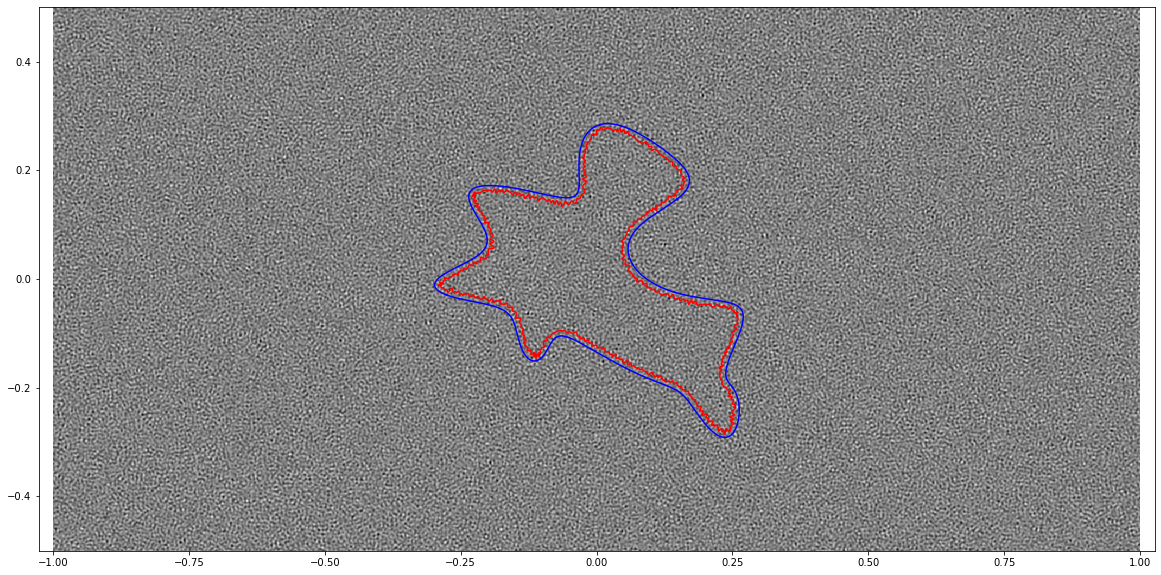

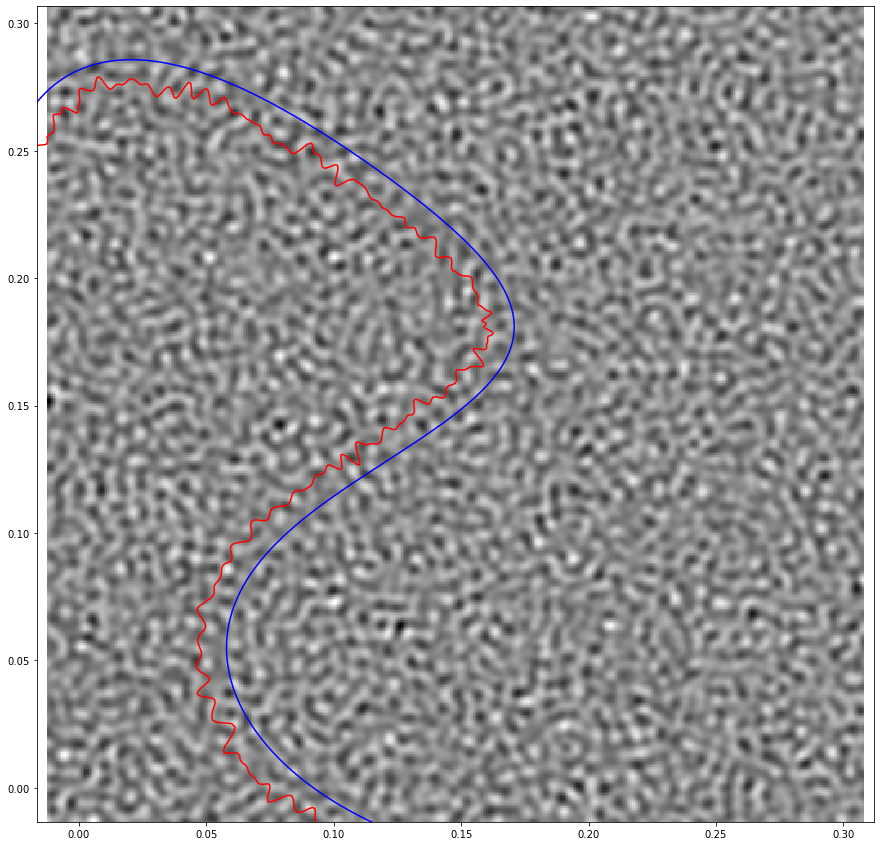

In [3]:
kmax = 1001#2000
L = 0.04#16#0.04
LAmp = 0.0

eps = 0.008
epsAmp = 0.02

a = 1/2
dom = [[-1,1], [-a, a]]

lerp, x, y = fourierGP_2D_lerp(kmax, kmax, L, LAmp, eps, epsAmp, dom)
X,Y = np.meshgrid(x, y)

#p = 1
#corner = lambda x,y : np.exp(-(1e-3**p)/(np.abs(np.abs(x)-.3)**2+np.abs(np.abs(y)-.3)**2)**p)
#x_s, y_s, x_n, y_n = square(500)
x_s, y_s, x_n, y_n = loop(8000, 0.3)
d_s = lerp(x_s, y_s) #* 3 * corner(x_s, y_s)


# FIeld
plt.figure(figsize=(20,10))
plt.pcolormesh(X, Y, lerp.Z, cmap='gray')
plt.plot(x_s - d_s * x_n, y_s - d_s * y_n, 'r')
plt.plot(x_s, y_s, 'b')
plt.axis('equal')
plt.xlim(*dom[0])
plt.ylim(*dom[1])


# Zoom
plt.figure(figsize=(15, 15))
w = 20
x0 = x_s[0]
y0 = y_s[0]
zoomdom = [[x0-eps*w, x0+eps*w], [y0-eps*w, y0+eps*w]]
xz = np.linspace(*zoomdom[0], 500)
yz = np.linspace(*zoomdom[1], 500)
Xz, Yz = np.meshgrid(xz, yz)
plt.pcolormesh(Xz, Yz, lerp(Xz.flatten(), Yz.flatten()).reshape(Xz.shape), cmap='gray')

xr, yr = x_s - d_s * x_n, y_s - d_s * y_n
plt.plot(xr, yr, 'r')
plt.plot(x_s, y_s, 'b')
plt.axis('equal')
plt.xlim(*zoomdom[0])
plt.ylim(*zoomdom[1])

<class 'ufl.geometry.FacetNormal'>


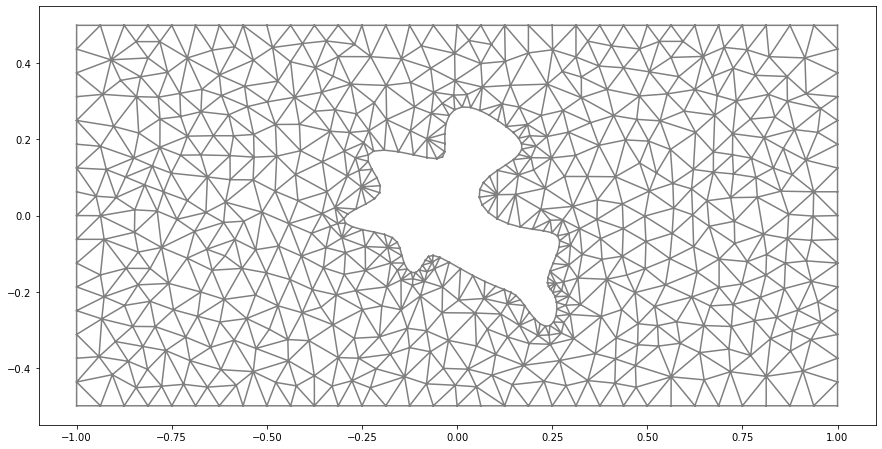

In [4]:
plt.figure(figsize=(15, 15))

class Blob(dl.SubDomain):
    def inside(self, x, on_boundary):
        #return bool(max(abs(x[0]), abs(x[1])) < 0.4 + dl.DOLFIN_EPS and on_boundary)
        return bool(max(abs(x[0]), abs(x[1]))<0.4)# and on_boundary)

def closest_on_segment(x: dl.Point, v: dl.Cell):
    """Closest distance between point x and line segment ab"""
    (a, b) = [v.point() for v in dl.vertices(v)]
    print(x, a, b)
    ab = b - a
    ax = x - a
    bx = x - b
    if ax.dot(ab) <= 0:
        return a
    elif -bx.dot(ab) <= 0:
        return b
    else:
        return a + ab * (ax.dot(ab) / ab.dot(ab))

pol = to_poly(x_s, y_s, 80)
domain = ms.Rectangle(dl.Point(dom[0][0], dom[1][0]), dl.Point(dom[0][1], dom[1][1])) - pol
mesh  = ms.generate_mesh(domain, resolution=20)

n = dl.FacetNormal(mesh)
print(type(n))
dl.plot(mesh)
#plt.xlim(*zoomdom[0])
#plt.ylim(*zoomdom[1])

In [63]:
from util.basis_scaled import ChebBasis, ScaleShiftedBasis, FourBasis
from boundary_solvers.geometry import RoundedMicroGeomGeneric

def generate_boundary_mesh_data(mesh: dl.Mesh, boundary: dl.SubDomain):
    bmesh = dl.BoundaryMesh(mesh, 'exterior')
    sbmesh = dl.SubMesh(bmesh, boundary)
    bbtree = dl.BoundingBoxTree()
    bbtree.build(sbmesh)
    
    boundary_mesh_map = bmesh.entity_map(1)
    submesh_mesh_map = sbmesh.data().array('parent_cell_indices', 1)
    mesh_map = np.array([boundary_mesh_map[submesh_mesh_map[i]] for i in range(len(submesh_mesh_map))])
    return sbmesh, bbtree, mesh_map
    

def closest_boundary_facet(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh):
    bid, _ = boundary_tree.compute_closest_entity(point)
    facet = dl.Facet(mesh, boundary_mesh_map[bid])
    return facet

def closest_point_on_facet(point, facet):
    pts = [v.point() for v in dl.vertices(facet)]
    a, b = pts
    ab = b - a
    ax = point - a
    bx = point - b
    if ax.dot(ab) <= 0:
        return a
    elif -bx.dot(ab) <= 0:
        return b
    else:
        return a + ab * (ax.dot(ab) / ab.dot(ab))
    
def plot_boundary_mesh(mesh, **kwargs):
    for f in dl.cells(mesh):
        pts = [v.point() for v in dl.vertices(f)]
        plt.plot([pts[0].x(), pts[1].x()], [pts[0].y(), pts[1].y()], **kwargs)
    
def project_to_boundary(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh):
    facet = closest_boundary_facet(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh)
    point = closest_point_on_facet(point, facet)
    normal = facet.normal()
    return point, normal

def closest_micro_geometry(point: dl.Point, roughness_field, boundary_mesh, boundary_tree, boundary_mesh_map, mesh, **geomargs):
    """Find closest point on boundary and normal to boundary at that point, 
    then construct a micro geometry from that point and normal with parameters specified in geomargs,
    normal_roughness must be a function for the offset of the roughness in the normal direction."""
    p, n = project_to_boundary(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh)
    width = geomargs.get('width', None)

    def local_roughness(t):
        t = (t - 0.25*np.pi) / (0.5*np.pi)
        x = p.x() - t*n.y()*width
        y = p.y() + t*n.x()*width
        return roughness_field(x, y)
    
    func = ScaleShiftedBasis.fromFunctionInDomain(local_roughness, [0, 0.5*np.pi], FourBasis, dim=11)
    dfunc = func.diff(1)
    ddfunc = func.diff(2)
    
    
    center = p.x() + 1j * p.y()
    normal = n.x() + 1j * n.y()
    return RoundedMicroGeomGeneric(func, dfunc, ddfunc, center=center, normal=normal, **geomargs)
    
    
    
    
#generate_boundary_mesh_data(mesh, Blob())

Building point search tree to accelerate distance queries.
Computed bounding box tree with 199 nodes for 100 points.


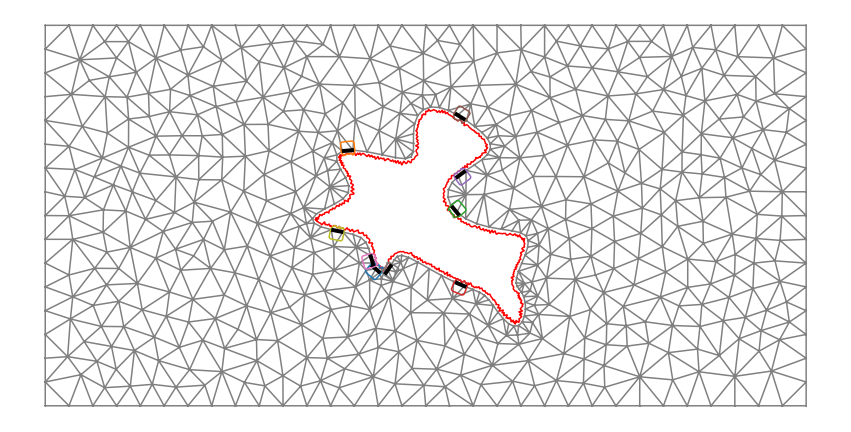

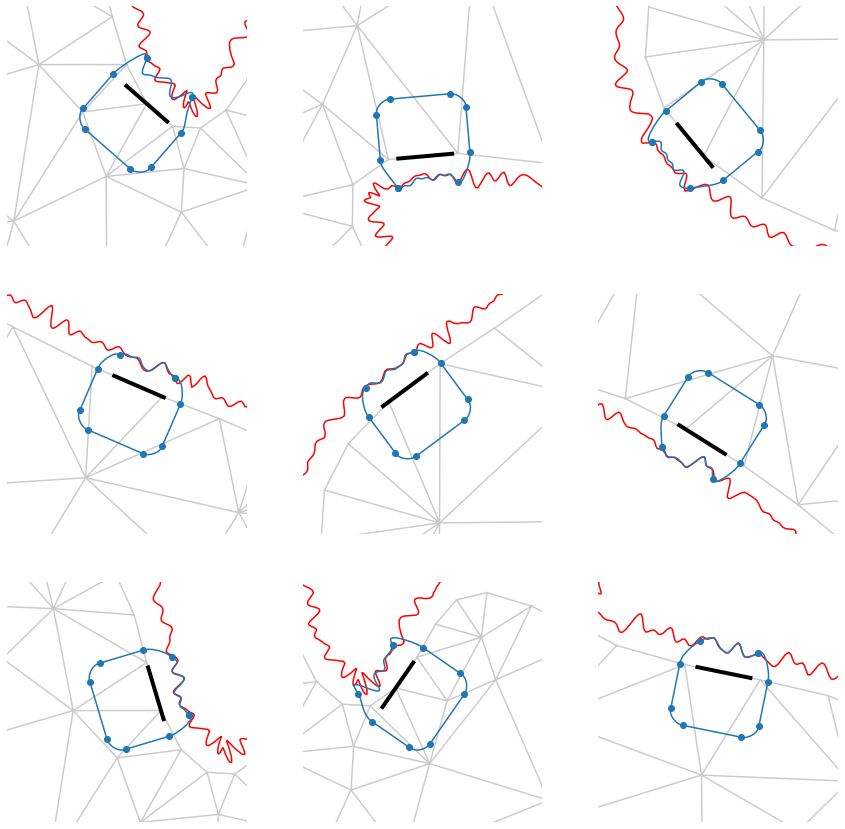

In [64]:
n = 3
scale = eps*3
x_mic = np.random.uniform(-0.25, 0.25, n*n)
y_mic = np.random.uniform(-0.25, 0.25, n*n)

plt.figure(figsize=(15, 15))
dl.plot(mesh)
remove_axes(plt.gca())
plt.plot(xr, yr, 'r')

plt.figure(figsize=(15, 15))

geoms = []
meshdata = generate_boundary_mesh_data(mesh, Blob())
for i, (xm, ym) in enumerate(zip(x_mic, y_mic)):
    geom = closest_micro_geometry(dl.Point(xm, ym), lambda x, y: 1.*lerp(x, y), 
                                  *meshdata, mesh, width=scale, height=scale, corner_w=scale/4, n_refine=0)
    geoms.append(geom)
    
    #print(f"Test {i}", end="\r")
    #test_adjoint(geom)
    
    #z = geom.inner_point
    #x, y = z.real, z.imag
    plt.figure(1)
    geom.plot(plt.gca())
    
    plt.figure(2)
    plt.subplot(n,n,i+1)
    z = geom.inner_point
    xm, ym = z.real, z.imag
    dl.plot(mesh, alpha=0.4)
    plt.plot(xr, yr, 'r')
    geom.plot(plt.gca(), showsegments=True)
    plt.xlim([xm-scale*2, xm+scale*2])
    plt.ylim([ym-scale*2, ym+scale*2])
    remove_axes(plt.gca())

[11 12]


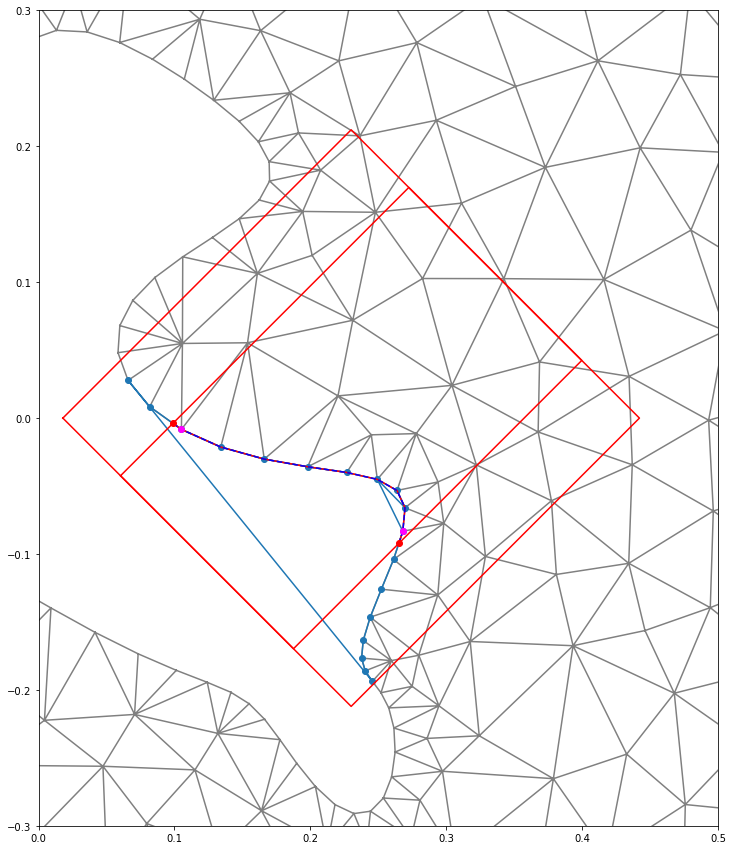

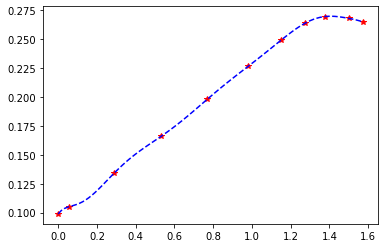

In [65]:
class MicroBox(dl.SubDomain):
    def __init__(self, center: dl.Point, normal: dl.Point, width: float, height: float):
        self.center = center
        self.width = width
        self.height = height
        self.tangent = np.array([-normal[1], normal[0]])
        self.normal = normal
        super(MicroBox, self).__init__()
        
    def inside(self, x, on_boundary):
        
        #return bool(max(abs(x[0]), abs(x[1])) < 0.4 + dl.DOLFIN_EPS and on_boundary)
        delta = x - self.center
        return bool( abs(np.dot(delta, self.tangent)) < self.width/2 - dl.DOLFIN_EPS  and
                    abs(np.dot(delta, self.normal)) < self.height/2 - dl.DOLFIN_EPS)

def find_intersection(mesh_1d, line_point, line_tangent):
    ## Find intersection and return the index of point to the right of the intersection, 
    ## right in the direction of the tangent
    
    line_normal = np.array([line_tangent[1], -line_tangent[0]]) 
    #left_edge = width /2 * tangent + center
    
    
    for edge in dl.cells(mesh_1d):
        verts = [v for v in dl.vertices(edge)]
        points = [v.point().array()[:2] for v in verts]
        dot_0 = np.dot(line_normal, points[0] - line_point)
        dot_1 = np.dot(line_normal, points[1] - line_point)
        if  dot_0 * dot_1 < 0:
            # find exact intersection
            t = abs(dot_0) / (abs(dot_1) + abs(dot_0))
            intersect = points[0] * (1-t) + points[1]*t
            # Return right point and intersection
            return intersect, verts[np.argmax([dot_0, dot_1])]
        else:
            pass
    raise ValueError("No intersection found, pick a better box")


def parameterise_left_2_right(mesh_1d, start_id, end_id, start_pt, end_pt, box):
    visited = dl.MeshFunction('bool', mesh_1d, 1)
    mesh_1d.init(0, 1)
    
    cur_vert = dl.Vertex(mesh_1d, start_id)
    points = [start_pt, cur_vert.point().array()[:2]]
    lengths = [0, np.linalg.norm(start_pt - cur_vert.point().array()[:2])]
    
    while cur_vert.index() != end_id:
        for e_id in cur_vert.entities(1):
            edge = dl.Cell(mesh_1d, e_id)
            if not visited.array()[e_id]:
                visited.array()[e_id] = True
                vert = [v for v in dl.vertices(edge) if v.index() != cur_vert.index()][0] # Only one 
                if box.inside(vert.point().array()[:2], True):
                    next_vert = vert
                else:
                    pass
        points.append(next_vert.point().array()[:2])
        lengths.append(np.linalg.norm(points[-1]-points[-2]))
        cur_vert = next_vert
                
    points = np.array(points + [end_pt])
    lengths = np.array(lengths + [np.linalg.norm(points[-1]-points[-2])])
    lengths = lengths / np.sum(lengths) # normalise
    t = np.cumsum(lengths) * 0.5 * np.pi
    return points , t    


    
    
#def fit_poly(points, t):
    

def plot_box(center, normal, width, height, color='red'):
    tangent = -np.array([normal[1], -normal[0]])
    pt_b_l = center - width/2 * tangent + height/2 * normal
    pt_b_r = center + width/2 * tangent + height/2 * normal
    pt_t_r = center + width/2 * tangent - height/2 * normal
    pt_t_l = center - width/2 * tangent - height/2 * normal
    plt.plot([pt_b_l[0], pt_b_r[0], pt_t_r[0], pt_t_l[0], pt_b_l[0]],\
             [pt_b_l[1], pt_b_r[1], pt_t_r[1], pt_t_l[1], pt_b_l[1]], color=color)
    

mfun = dl.MeshFunction("size_t", mesh, 1, 0)
MicroBox(np.array([.3,0]), np.array([1, 1])/np.sqrt(2), 0.3, 0.3).mark(mfun, 1)

center = np.array([.23,0])
normal = -np.array([1, 1])/np.sqrt(2)
width = 0.3
height= 0.3

sbmesh = dl.SubMesh(dl.BoundaryMesh(mesh, 'exterior'), MicroBox(center, normal, width, height))



plt.figure(figsize=(15, 15))
l_point, l_vert = find_intersection(sbmesh, center+width*0.3 * np.array([normal[1], -normal[0]]), -normal)
r_point, r_vert = find_intersection(sbmesh, center-width*0.3 * np.array([normal[1], -normal[0]]), normal)
points, t = parameterise_left_2_right(sbmesh, l_vert.index(), r_vert.index(), l_point, r_point, MicroBox(center, normal, width*0.3*2, height))

top = sbmesh.topology()#c00 = top(1, 0)
sbmesh.init(0, 1)
print(l_vert.entities(1))
#print(np.fromiter(c00(), dtype=int).reshape([sbmesh.num_cells(), 2]))
#print()#entities(1))

basis_x = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 0], [0, 0.5*np.pi], ChebBasis)
dbasis_x = basis_x.diff(1)
ddbasis_x = basis_x.diff(2)

basis_y = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 1], [0, 0.5*np.pi], ChebBasis)
dbasis_y = basis_y.diff(1)
ddbasis_y = basis_y.diff(2)

dl.plot(mesh)
dl.plot(sbmesh)
plt.plot(points[:,0], points[:,1], 'r')
plt.plot(basis_x(t), basis_y(t), 'b--')
#plt.quiver(basis_x(t), basis_y(t), dbasis_x(t), dbasis_y(t), color='green')

# plot pts
plt.scatter(l_point[0], l_point[1], c='red', zorder=10)
plt.scatter(l_vert.point().x(), l_vert.point().y(), c='magenta', zorder=11)
plt.scatter(r_point[0], r_point[1], c='red', zorder=10)
plt.scatter(r_vert.point().x(), r_vert.point().y(), c='magenta', zorder=11)

plot_box(center, normal, width, height, color='red')
plot_box(center, normal, width*0.3*2, height, color='red')

plt.xlim([0, 0.5])
plt.ylim([-0.3, 0.3])

plt.figure()
ts = np.linspace(0,0.5*np.pi, 100)
plt.plot(t, points[:,0], 'r*')
#plt.plot(t, points[:,1], 'r')
plt.plot(ts, basis_x(ts), 'b--')
#plt.plot(t, dbasis_x(t), 'b--')
    

Building point search tree to accelerate distance queries.
Computed bounding box tree with 199 nodes for 100 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 199 nodes for 100 points.


/home/emastr/phd/notebooks/../boundary_solvers/geometry.py:542: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = lambda t: a + (b-a)*(t-t0)/(t1-t0)
/home/emastr/phd/notebooks/../boundary_solvers/geometry.py:543: RuntimeWarning: divide by zero encountered in cdouble_scalars
  dz = lambda t: (b-a)*np.ones_like(t)/(t1-t0)
/home/emastr/phd/notebooks/../boundary_solvers/geometry.py:542: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = lambda t: a + (b-a)*(t-t0)/(t1-t0)
/home/emastr/phd/notebooks/../boundary_solvers/geometry.py:543: RuntimeWarning: divide by zero encountered in cdouble_scalars
  dz = lambda t: (b-a)*np.ones_like(t)/(t1-t0)


(-0.2, 0.2)

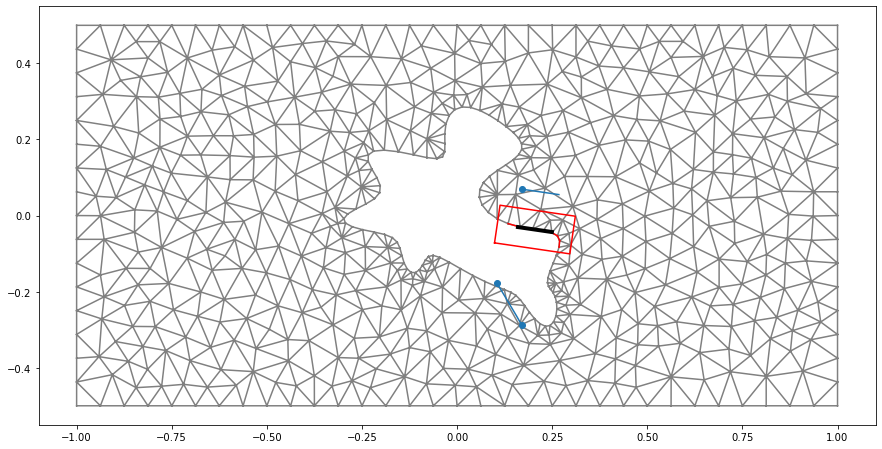

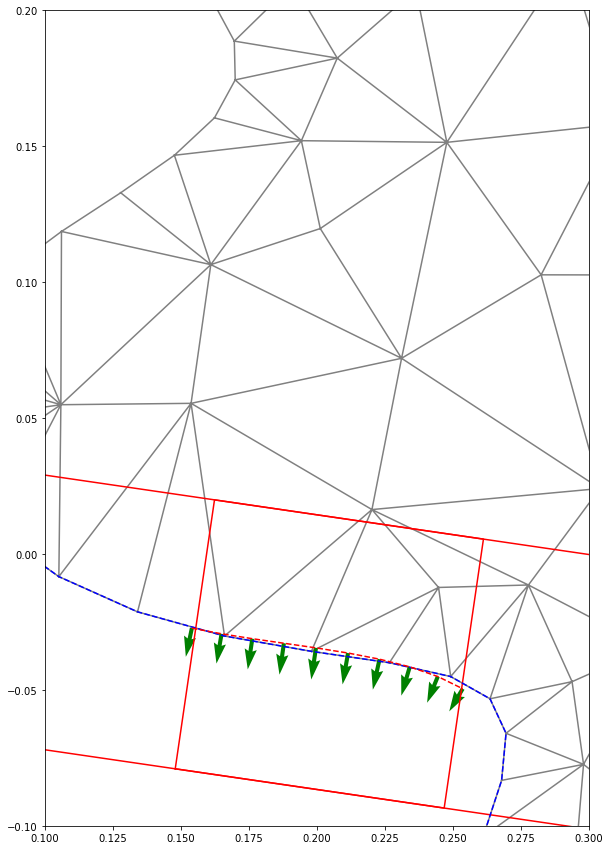

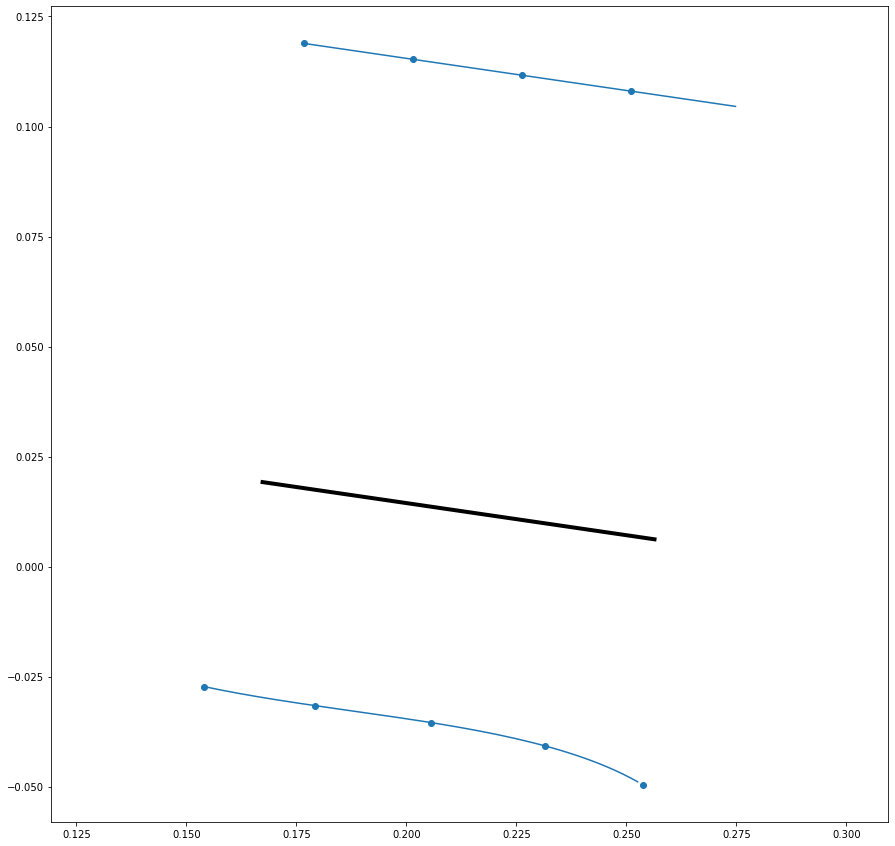

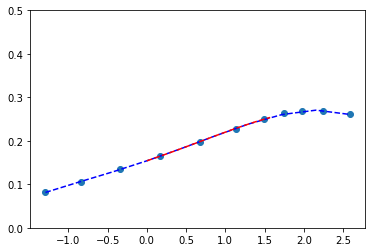

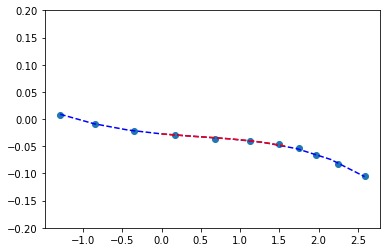

In [97]:
class MicroBox(dl.SubDomain):
    def __init__(self, center: dl.Point, normal: dl.Point, width: float, height: float):
        self.center = center
        self.width = width
        self.height = height
        self.tangent = np.array([-normal[1], normal[0]])
        self.normal = normal
        super(MicroBox, self).__init__()
        
    def inside(self, x, on_boundary):
        
        #return bool(max(abs(x[0]), abs(x[1])) < 0.4 + dl.DOLFIN_EPS and on_boundary)
        delta = x - self.center
        return bool( abs(np.dot(delta, self.tangent)) < self.width/2 - dl.DOLFIN_EPS  and
                    abs(np.dot(delta, self.normal)) < self.height/2 - dl.DOLFIN_EPS)

def find_intersection(points, line_point, line_tangent):
    """Find intersection and return the index of point to the right of the intersection, 
    right in the direction of the tangent"""
    line_normal = np.array([line_tangent[1], -line_tangent[0]]) 
    
    for i in range(points.shape[0]-1):
        x0, x1 = points[i], points[i+1]
        dot_0 = np.dot(line_normal, x0 - line_point)
        dot_1 = np.dot(line_normal, x1 - line_point)
        if  dot_0 * dot_1 < 0:
            # find exact intersection
            t = abs(dot_0) / (abs(dot_1) + abs(dot_0))
            intersect = x0 * (1-t) + x1 * t
            # Return right point and intersection
            return intersect, i
        else:
            pass
    raise ValueError("No intersection found, pick a better box")


def order_connected_vertices(mesh_1d):
    """Assuming vertices are connected, order them in the direction of the mesh"""
    mesh_1d.init(0, 1)
    visited = dl.MeshFunction("bool", mesh_1d, False)
    
    start_edge = dl.Edge(mesh_1d, 0)
    visited.array()[start_edge.index()] = True
    
    right_vert = dl.Vertex(mesh_1d, start_edge.entities(0)[1])
    left_vert = dl.Vertex(mesh_1d, start_edge.entities(0)[0])
    indices = [left_vert.index(), right_vert.index()]
    
    # Right search
    while len(right_vert.entities(1)) > 1:
        edge = dl.Edge(mesh_1d, [e for e in right_vert.entities(1) if not visited.array()[e]][0])
        right_vert = dl.Vertex(mesh_1d, [v for v in edge.entities(0) if v != right_vert.index()][0])
        indices = indices + [right_vert.index()]
        visited.array()[edge.index()] = True
    
    # Left search
    while len(left_vert.entities(1))> 1:
        edge = dl.Edge(mesh_1d, [e for e in left_vert.entities(1) if not visited.array()[e]][0])
        left_vert = dl.Vertex(mesh_1d, [v for v in edge.entities(0) if v != left_vert.index()][0])
        indices = [left_vert.index()] + indices
        visited.array()[edge.index()] = True
        
    return indices

def curve_length(curve):
    lengths = np.zeros(curve.shape[0])
    lengths[1:] = np.linalg.norm(curve[1:, :] - curve[:-1, :], axis=1)
    return np.cumsum(lengths)

def reparameterize_curve(curve, length, left_point, right_point, normal, dom):
    p_left, i_left = find_intersection(curve, left_point, normal)
    p_right, i_right = find_intersection(curve, right_point, normal)
    
    l_left = length[i_left] + np.linalg.norm(p_left - curve[i_left])
    l_right = length[i_right] + np.linalg.norm(p_right - curve[i_right])
    
    scale, shift = ScaleShiftedBasis._domain_to_scale_shift([l_left, l_right], dom)
    return scale*(length - shift)
    

def closest_micro_geometry(point, fine_boundary_mesh, boundary_mesh, boundary_tree, boundary_mesh_map, mesh, **geomargs):
    """Find closest point on boundary and normal to boundary at that point, 
    then construct a micro geometry from that point and normal with parameters specified in geomargs,
    normal_roughness must be a function for the offset of the roughness in the normal direction."""
    center, normal = project_to_boundary(dl.Point(point[0], point[1]), boundary_mesh, boundary_tree, boundary_mesh_map, mesh)
    center = center.array()[:2]
    normal = normal.array()[:2]
    tangent = np.array([-normal[1], normal[0]])
    width = geomargs.get('width', 1.0)
    height = geomargs.get('height', 1.0)
    corner_w = geomargs.get('corner_w', 0.1)
    corner_l = center - width * tangent/2
    corner_r = center + width * tangent/2

    bbox = MicroBox(center, normal, width + 2*corner_w, height)
    boxMesh = dl.SubMesh(fine_boundary_mesh, bbox)
    
    dl.plot(mesh)
    plot_boundary_mesh(boxMesh, color='red')
    plot_box(center, normal, width+2*corner_w, height, color='red')
    
    indices = order_connected_vertices(boxMesh)
    points = np.array([v[:2] for v in boxMesh.coordinates()])[indices]
    length = curve_length(points)
    t = reparameterize_curve(points, length, corner_l, corner_r, normal, [0, 0.5*np.pi])
    

    f_x = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 0], [t[0], t[-1]], ChebBasis, dim=len(t)//2)
    df_x = f_x.diff(1)
    ddf_x = f_x.diff(2)
    
    f_y = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 1], [t[0], t[-1]], ChebBasis, dim=len(t)//2)
    df_y = f_x.diff(1)
    ddf_y = f_x.diff(2)
    
    
    f = lambda t: f_x(t) + 1j * f_y(t)
    df = lambda t: df_x(t) + 1j * df_y(t)
    ddf = lambda t: ddf_x(t) + 1j * ddf_y(t)
    
    center_c = center[0] + 1j * center[1]
    normal_c = normal[0] + 1j * normal[1]
    return RoundedMicroGeomGeneric(f, df, ddf, center=center_c, normal=normal_c, **geomargs)
    


mfun = dl.MeshFunction("size_t", mesh, 1, 0)
MicroBox(np.array([.3,0]), np.array([1, 1])/np.sqrt(2), 0.3, 0.3).mark(mfun, 1)

center = np.array([.21,0])

c, n = project_to_boundary(dl.Point(center[0], center[1]), *generate_boundary_mesh_data(mesh, Blob()), mesh)
center = c.array()[:2]
normal = n.array()[:2]

#normal = -np.array([1, 1])/np.sqrt(2)
tangent = np.array([-normal[1], normal[0]])
width = 0.1
height= 0.1
pad = 0.08
corner_w = 0.05

## 
plt.figure(figsize=(15, 15))
boundary_mesh, boundary_tree, boundary_mesh_map = generate_boundary_mesh_data(mesh, Blob())
geom = closest_micro_geometry(center, boundary_mesh, boundary_mesh, boundary_tree, boundary_mesh_map, mesh, 
                               width=width, height=height, corner_w=corner_w, n_refine=0)
geom.plot(plt.gca(), showsegments=True)

### Create micro geometry
sbmesh = dl.SubMesh(dl.BoundaryMesh(mesh, 'exterior'), MicroBox(center, normal, width+2*pad, height*1.5))
indices = order_connected_vertices(sbmesh)
points = np.array([v[:2] for v in sbmesh.coordinates()])[indices]
length = curve_length(points)

t = reparameterize_curve(points, length, center - tangent * width/2, center + tangent * width/2, normal, [0, 0.5*np.pi])

f_x = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 0], [t[0], t[-1]], ChebBasis, dim=len(t)//2)
df_x = f_x.diff(1)
ddf_x = f_x.diff(2)

f_y = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 1], [t[0], t[-1]], ChebBasis, dim=len(t)//2)
df_y = f_y.diff(1)
ddf_y = f_y.diff(2)

center_c = center[0] + 1j * center[1]
normal_c = normal[0] + 1j * normal[1]

#f = lambda t: (1+np.sin(t))*normal_c*0.01 + center_c + normal_c*(t-0.25*np.pi) * width / (0.5 * np.pi*1j)#f_x(t) + 1j * f_y(t)
#df = lambda t: np.cos(t)*normal_c*0.01 + normal_c * width/(0.5*np.pi*1j)# df_x(t) + 1j * df_y(t)
#ddf = lambda t: -np.sin(t)*normal_c*0.01#ddf_x(t) + 1j * ddf_y(t)

f = lambda t: f_x(t) + 1j * f_y(t)
df = lambda t: df_x(t) + 1j * df_y(t)
ddf = lambda t: ddf_x(t) + 1j * ddf_y(t)


geom2 = RoundedMicroGeomGeneric(f, df, ddf, center=center_c-normal_c*0.05, normal=normal_c, width=width, height=height, 
                                corner_w=corner_w, n_refine=2, simple_func=False)

t2 = np.linspace(0, 0.5*np.pi, 10)
t1 = np.linspace(t[0], t[-1], 10)
b = f(t2)
db = df(t2)

plt.figure(figsize=(15, 15))
dl.plot(mesh)
plot_box(center, normal, width+2*pad, height, color='red')
plot_box(center, normal, width, height, color='red')

plt.plot(points[:,0], points[:,1], 'b--')
plt.plot(b.real, b.imag, 'r--')
plt.quiver(b.real, b.imag, db.imag, -db.real, color='green')
plt.xlim([0.1, 0.3])
plt.ylim([-0.1, 0.2])

plt.figure(figsize=(15,15))
geom2.plot(plt.gca(), showsegments=True)
plt.axis('equal')

#plt.plot(b_x, b_y, 'b--')
#plt.plot()
#plt.axis('equal')


# PLOT
plt.figure()
plt.scatter(t, points[:,0])
plt.plot(t1, f(t1).real, 'b--')
plt.plot(t2, f(t2).real, 'r--')
plt.ylim([0, 0.5])

plt.figure()
plt.scatter(t, points[:,1])
plt.plot(t1, f(t1).imag, 'b--')
plt.plot(t2, f(t2).imag, 'r--')
plt.ylim([-0.2, 0.2])


(-1.1132114768028258,
 1.3774410128593444,
 -1.1132114768028258,
 1.3774410128593444)

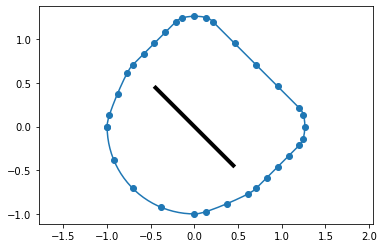

In [78]:

f = lambda t: np.exp(1j *t + np.pi*1j)#f_x(t) + 1j * f_y(t)
df = lambda t: f(t)*1j
ddf = lambda t: -f(t) #ddf_x(t) + 1j * ddf_y(t)



geom2 = RoundedMicroGeomGeneric(f, df, ddf, center=-0.0, normal=-(1j+1)/np.sqrt(2), width=0.7*2, height=1., 
                                corner_w=0.3, n_refine=2, simple_func=False)

geom2.plot(plt.gca(), showsegments=True)
plt.axis('equal')

AttributeError: 'dolfin.cpp.mesh.MeshFunctionSizet' object has no attribute 'mark'

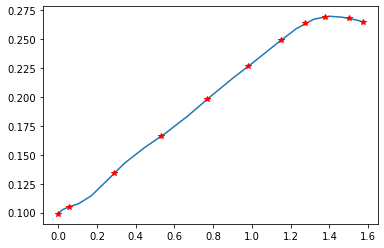

In [42]:
bas= ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 0].flatten(), [0, 0.5*np.pi], ChebBasis)
bas.plot(plt.gca(), 21)
#bas.diff(1).plot(plt.gca(), 21)
plt.plot(t, points[:, 0], 'r*')


Building point search tree to accelerate distance queries.
Computed bounding box tree with 199 nodes for 100 points.


(-0.5482412267540456,
 0.542787023648972,
 -0.31982333121504897,
 0.3141505486564018)

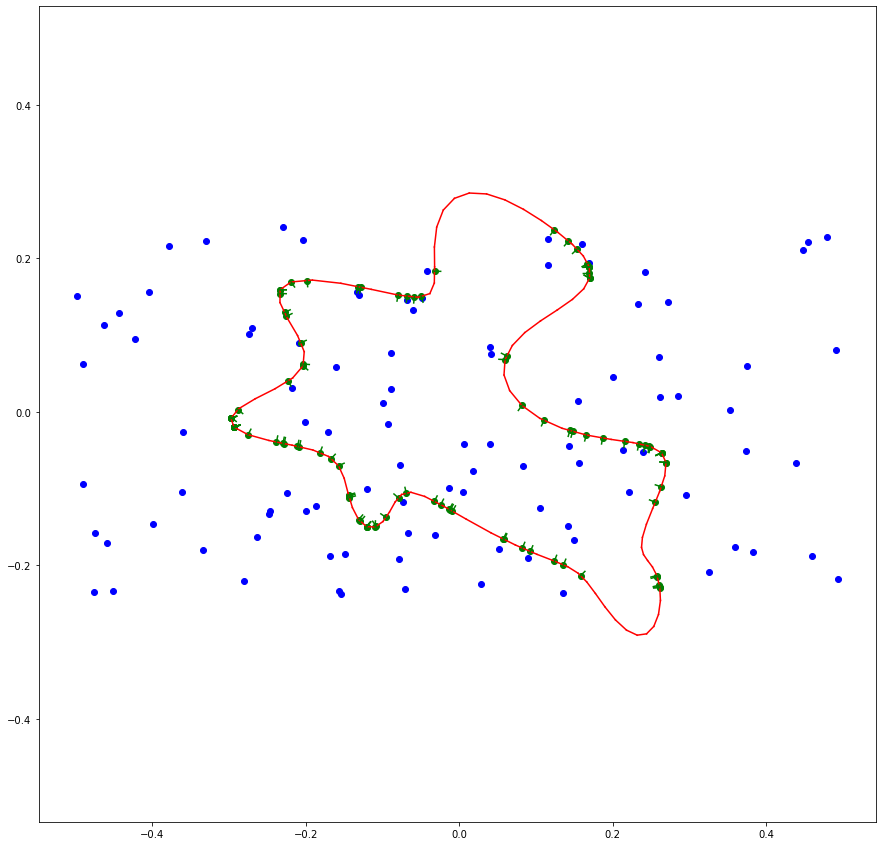

In [ ]:
plt.figure(figsize=(15,15))

bmesh, bbtree, bmap = generate_boundary_mesh_data(mesh, Blob())
plot_boundary_mesh(bmesh, color='r')
x = np.random.uniform(dom[0][0]/2, dom[0][1]/2, 100)
y = np.random.uniform(dom[1][0]/2, dom[1][1]/2, 100)
points = [dl.Point(x[i], y[i]) for i in range(len(x))]
for point in points:
    p, n = project_to_boundary(point, bmesh, bbtree, bmap, mesh)
    plt.scatter(point.x(), point.y(), c='b')
    plt.scatter(p.x(), p.y(), c='g')
    
    plt.plot([p.x(), p.x()+eps*n.x()], [p.y(), p.y()+eps*n.y()], c='g')

plt.axis('equal')
    
#dl.plot(bmesh

In [8]:
import sys
sys.path.append('../tests/')
import pytest as pt

!pytest "/home/emastr/phd/tests/" #test_geometry.py"

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-7.3.1, pluggy-1.0.0
rootdir: /home/emastr/phd
collected 1 item                                                               

../tests/test_geometry.py .                                              [100%]

=============================== warnings summary ===============================
tests/test_geometry.py::test_adjoint
tests/test_geometry.py::test_adjoint
  <decorator-gen-5>:2: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``gmres(..., atol=0)``, or to retain the old behavior ``gmres(..., atol='legacy')``

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
======================== 1 passed, 2 warnings in 5.91s =========================


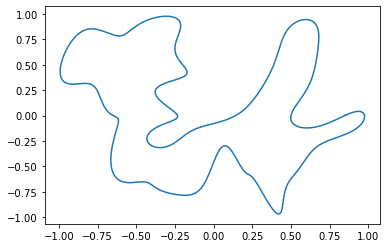

In [9]:
K = 21
cs = smooth_random_loop_fourier_coef(K)
ks = np.arange(-K, K, 1)
f = lambda t: (np.exp(1j * ks[None, :] * t[:, None]) @ cs).real
df = lambda t: (1j * ks[None, :] * np.exp(1j * ks[None, :] * t[:, None]) @ cs).real
            
t = np.linspace(0, 2*np.pi, 500)
xy = f(t)

plt.plot(xy[:,0], xy[:,1])

(0.9396408587694168, 1.1194326490163804, 1.939561700820923, 2.1194020748138427)

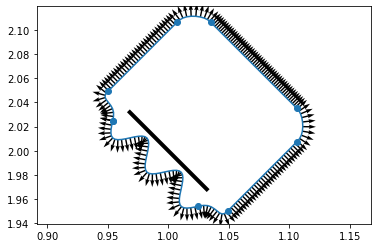

In [10]:
import sys
sys.path.append('../')
from boundary_solvers.geometry import RoundedMicroGeomGeneric
import matplotlib.pyplot as plt
import numpy as np

k = 10
width = 0.1
height = 0.1
center = 1+2j
normal = -(1+1j)/2**0.5
tangent = normal* 1j
corner_w = 0.02
eps = 0.01

corner1 = center - 0* height/2 * normal + width/2 * tangent + corner_w * tangent

func = lambda t: np.sin(k*t) * eps + eps * 1.5
dfunc = lambda t: k*np.cos(k*t) * eps
ddfunc = lambda t: -k**2*np.sin(k*t) * eps

geom = RoundedMicroGeomGeneric(func, dfunc, ddfunc, center, width, height, normal, corner_w, n_refine=0, n_corner_refine=0, simple_func=True)
#geom = RoundedMicroGeom(lambda t: -func(t), lambda t: -dfunc(t), lambda t: -ddfunc(t), 
#                        width, height, corner_w, line_pos=0, center_x=center.real, shift_y=center.imag, n_refine=3, n_corner_refine=0)
geom.plot(plt.gca(), showsegments=True, shownormals=True)
plt.axis('equal')